In [1]:
import os, glob, shutil
import urllib.request as r
import kaggle 

def data_yuklab_olish(saqlash_uchun_papka, data_nomi = "lentils"): 
    
    data_nomlari = ["salaries", "exams", "college", "cars", "mall", "customers", "humanitarian", "rice_leaf_disease", "lentils"]
    assert data_nomi in data_nomlari, f"Mavjud bo'lgan dataset {data_nomlari} dan birini kiriting!"
    
    if data_nomi == "rice_leaf_disease": url = "kaggle datasets download -d killa92/rice-leaf-disease-classification-dataset"
    elif data_nomi == "lentils": url = "kaggle datasets download -d killa92/lentils-classification-dataset"
    
    # Download from the checkpoint path
    if os.path.isfile(f"{saqlash_uchun_papka}/{data_nomi}.csv") or os.path.isdir(f"{saqlash_uchun_papka}/{data_nomi}"): print(f"Dataset yuklab olingan. {saqlash_uchun_papka}/{data_nomi} papkasini ni tekshiring."); pass

    # If the checkpoint does not exist
    else: 
        ds_nomi = url.split("/")[-1]
        full_path = f"{saqlash_uchun_papka}/{ds_nomi}"
        print(f"{data_nomi} dataset yuklanmoqda...")
        # Download the dataset
        os.system(f"{url} -p {full_path}")
        shutil.unpack_archive(f"{full_path}/{ds_nomi}.zip", f"{saqlash_uchun_papka}/{ds_nomi}")
        os.remove(f"{full_path}/{ds_nomi}.zip")
        os.rename(f"{saqlash_uchun_papka}/{ds_nomi}", f"{saqlash_uchun_papka}/{data_nomi}")
        print(f"Tanlangan dataset {saqlash_uchun_papka}/{data_nomi} papkasiga yuklab olindi!")
    
# data_yuklab_olish(saqlash_uchun_papka = "mening_malumotlarim", data_nomi = "lentils")
data_yuklab_olish(saqlash_uchun_papka = "mening_malumotlarim", data_nomi = "rice_leaf_disease")

Dataset yuklab olingan. mening_malumotlarim/rice_leaf_disease papkasini ni tekshiring.


In [115]:
import os 
from torch.utils.data import Dataset, DataLoader, random_split 
from torchvision import transforms as T 
from glob import glob 
from PIL import Image

class RiceDataset(Dataset):

    def __init__(self, data_yulagi, transformations=None): 
        self.rasm_yulaklari = glob(os.path.join(f"{data_yulagi}/*/*.jp*g"))
        self.transformations = transformations 
        print(len(self.rasm_yulaklari))
        
        self.klass_ismi = {}
        klass_qiymati = 0
        
        for i, yul in enumerate(self.rasm_yulaklari):
            
            klass_ismi = self.klassni_olib_kelish (yul)
            if not klass_ismi in self.klass_ismi: self.klass_ismi[klass_ismi] = klass_qiymati; klass_qiymati +=1

    def __len__(self): 
        return len(self.rasm_yulaklari)

    def klassni_olib_kelish(self, yulak): 
        return os.path.dirname(yulak).split(os.sep)[-1]

    def __getitem__(self, idx): 
        rasm = Image.open(self.rasm_yulaklari[idx])
                                                                      
        if self.transformations: 
            rasm = self.transformations(rasm)
    
        javob = self.klass_ismi[self.klassni_olib_kelish(self.rasm_yulaklari[idx])]
     
        return rasm, javob   

tfs = T.Compose([T.Resize((224,224)), T.ToTensor() , T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])                                                                      
ds = RiceDataset(data_yulagi="mening_malumotlarim/rice_leaf_disease/Rice Leaf  Disease Dataset", transformations=tfs)
ts_ds  = RiceDataset(data_yulagi="mening_malumotlarim/rice_leaf_disease/Rice Leaf  Disease Dataset", transformations=tfs)
print(len(ds))
# print(type(ds)[10][0])
# print(type(ds)[10][1])
print(ds.klass_ismi)
klass_ismi = ds.klass_ismi

ismlar = klass_ismi.keys()
ism_kalitlari = list(ismlar)




print(ism_kalitlari)

591
591
591
{'Brown Spot': 0, 'False smut': 1, 'Healthy': 2, 'Material Leaf Blight': 3, 'Rice Blast': 4, 'sheath_blight': 5, 'Stem rot': 6, 'Tungro': 7}
['Brown Spot', 'False smut', 'Healthy', 'Material Leaf Blight', 'Rice Blast', 'sheath_blight', 'Stem rot', 'Tungro']


In [80]:
sample_rasm, sample_javob = ds[0]
print("Type of rasm:", type(sample_rasm))
print("Type of javob:", type(sample_javob))

Type of rasm: <class 'torch.Tensor'>
Type of javob: <class 'int'>


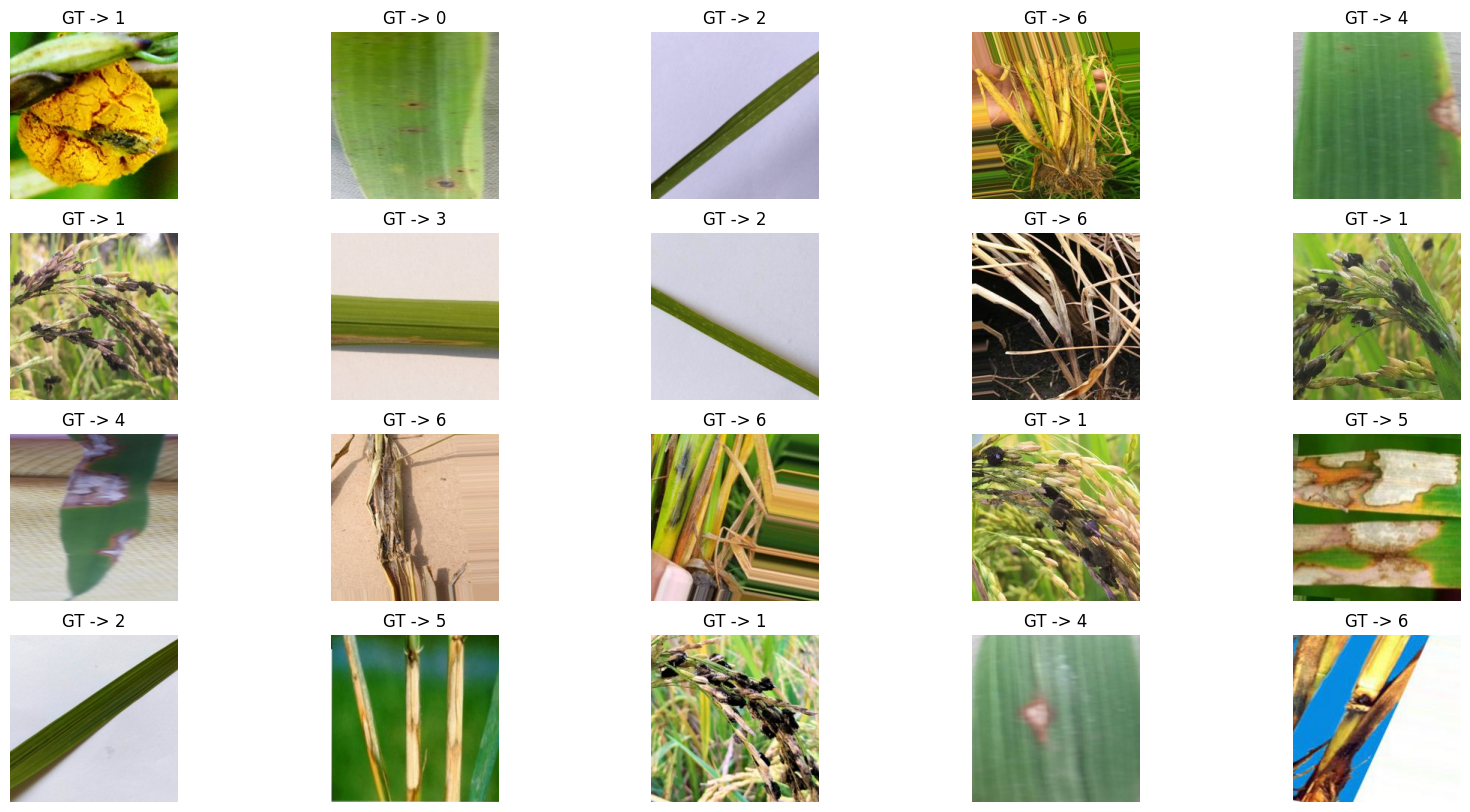

In [114]:
from utils import visualize
visualize(data = ds, rasmlar_soni = 20, qatorlar = 4, cmap = 'gray' )

In [45]:
split = [0.8 , 0.1, 0.1]
all_len = len(ds)
tr_len = int(all_len *split[0])
val_len = int(all_len * split[1])
ts_len = all_len-tr_len-val_len
print(len(ds))
print(tr_len)
print(val_len)
print(ts_len)

591
472
59
60


In [46]:
tr_ds, val_ds, ts_ds = random_split(dataset=ds, lengths=[tr_len, val_len, ts_len])
print(len(tr_ds))
print(len(val_ds))
print(len(ts_ds))
                                 

472
59
60


In [47]:
bs = 16

tr_dl = DataLoader(dataset = tr_ds , batch_size = bs , shuffle = True , num_workers = 0)
val_dl = DataLoader(dataset = val_ds , batch_size = bs , shuffle = False , num_workers = 0)
ts_dl = DataLoader(dataset = ts_ds , batch_size = bs , shuffle = False , num_workers = 0)


print(len(tr_dl))
print(len(val_dl))
print(len(ts_dl))
                

30
4
4


In [48]:
import timm
model = timm.create_model(model_name = "resnet18", pretrained = True , num_classes = len(klass_ismi))
model                           

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act1): ReLU(inplace=True)
      (aa): Identity()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

In [49]:
import torch
from torch import nn


class Model(nn.Module):



    def __init__(self, in_chs, out_chs,in_fs, ks,s, p, n_cls) :
        super().__init__()

        self.conv_1 = nn.Conv2d(in_channels=in_chs, out_channels = out_chs, kernel_size=ks, stride= s, padding = p)
        self.conv_2 = nn.Conv2d(in_channels=out_chs, out_channels = out_chs*2, kernel_size=ks, stride= s, padding = p)
        self.conv_3 = nn.Conv2d(in_channels=out_chs*2, out_channels = out_chs*4, kernel_size=ks, stride= s, padding = p)

        self.linear_1 = nn.Linear(in_features=in_fs, out_features= in_fs // 2)
        self.linear_2 = nn.Linear(in_features=in_fs //2 , out_features= n_cls)
        self.act = nn.ReLU()
        self.mp = nn.MaxPool2d(kernel_size =2, stride = 2)


    def forward(self, inp):

      out = self.conv_1(inp)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_2(out)
      out = self.act(out)
      out = self.mp(out)

      out = self.conv_3(out)
      out = self.act(out)
      out = self.mp(out)

      print(out.shape)

      bs= inp.shape[0]
      out = out.view(bs, -1)

      out= self.linear_1(out)
      out = self.act(out)
      out = self.linear_2(out)

      return out

rasm = torch.rand(1, 3, 224, 224)
model = Model(in_chs = 3, out_chs=8, in_fs= 25088 , ks=3 , s=1, p=1, n_cls=8)
model(rasm).shape

torch.Size([1, 32, 28, 28])


torch.Size([1, 8])

In [50]:
epochs = 5
device = "cpu" #"cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
model.train()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

In [51]:
from tqdm import tqdm
import os

best_acc = 0
prefix = "rice_leaf_desease"

for epoch in range(epochs):
    model.train()
    print(f"{epoch + 1} - epoch jarayonlari boshlandi")

    epoch_loss, epoch_acc, total = 0, 0, 0

    for i, batch in tqdm(enumerate(tr_dl)):
        rasm, javob = batch
        print(type(javob))
        #labels = labels.to(device)
        rasm, javob = rasm.to(device), javob.to(device)
        total += rasm.shape[0]

        preds = model(rasm)
        loss = loss_fn(preds, javob)
        pred_cls = torch.argmax(preds.data, dim=1)
        epoch_acc += (pred_cls == javob).sum().item()
        epoch_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print(f"{epoch + 1} - epoch train jarayoni natijalari :")
    print(f" {epoch + 1}- epochdagi train loss     -> {(epoch_loss / len(tr_dl)):.3f}")
    print(f" {epoch + 1}- epochdagi train accuracy     -> {(epoch_acc / total):.3f}")

    model.eval()
    with torch.no_grad():
        val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0

        for ids, batch in tqdm(enumerate(val_dl)):
            rasm, javob = batch
            rasm, javob = rasm.to(device), javob.to(device)
            val_total += rasm.shape[0]

            preds = model(rasm)
            loss = loss_fn(preds, javob)
            pred_cls = torch.argmax(preds.data, dim=1)

            val_epoch_acc += (pred_cls == javob).sum().item()
            val_epoch_loss += loss.item()

            val_acc = val_epoch_acc / val_total

    print("\n ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~\n")
    print(f"{epoch + 1} - epoch validation jarayoni natijalari :")
    print(f" {epoch + 1}- epochdagi validation loss     -> {(val_epoch_loss / len(val_dl)):.3f}")
    print(f" {epoch + 1}- epochdagi validation accuracy     -> {(val_acc):.3f}")

    if val_acc > best_acc:
        os.makedirs("modellar", exist_ok=True)
        best_acc = val_acc
        torch.save(model.state_dict(), f"modellar/{prefix}_best_model.pth")


1 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


1it [00:16, 16.35s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


2it [00:27, 13.27s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


3it [00:36, 11.43s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


4it [00:46, 10.79s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


5it [00:53,  9.40s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


6it [01:03,  9.75s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


7it [01:13,  9.80s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


8it [01:23,  9.93s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


9it [01:32,  9.63s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


10it [01:43,  9.93s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


11it [01:52,  9.74s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


12it [02:00,  9.22s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


13it [02:09,  9.14s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


14it [02:18,  9.11s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


15it [02:29,  9.44s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


16it [02:39,  9.65s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


17it [02:47,  9.14s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


18it [02:56,  9.33s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


19it [03:06,  9.47s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


20it [03:16,  9.46s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


21it [03:27,  9.87s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


22it [03:37,  9.95s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


23it [03:49, 10.56s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


24it [04:02, 11.34s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


25it [04:13, 11.39s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


26it [04:23, 10.96s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


27it [04:33, 10.63s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


28it [04:43, 10.52s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


29it [04:52, 10.10s/it]

<class 'torch.Tensor'>
torch.Size([8, 32, 28, 28])


30it [05:02, 10.09s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1 - epoch train jarayoni natijalari :
 1- epochdagi train loss     -> 2.828
 1- epochdagi train accuracy     -> 0.292


0it [00:00, ?it/s]

torch.Size([16, 32, 28, 28])


1it [00:00,  1.80it/s]

torch.Size([16, 32, 28, 28])


2it [00:01,  1.58it/s]

torch.Size([16, 32, 28, 28])


3it [00:01,  1.95it/s]

torch.Size([11, 32, 28, 28])


4it [00:01,  2.04it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

1 - epoch validation jarayoni natijalari :
 1- epochdagi validation loss     -> 1.515
 1- epochdagi validation accuracy     -> 0.407
2 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


1it [00:10, 10.26s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


2it [00:21, 10.96s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


3it [00:31, 10.63s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


4it [00:41, 10.22s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


5it [00:51,  9.99s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


6it [01:03, 10.65s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


7it [01:15, 11.14s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


8it [01:25, 10.88s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


9it [01:38, 11.59s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


10it [01:48, 11.08s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


11it [01:59, 10.91s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


12it [02:09, 10.76s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


13it [02:19, 10.39s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


14it [02:31, 11.04s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


15it [02:46, 12.10s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


16it [02:57, 11.95s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


17it [03:05, 10.80s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


18it [03:16, 10.79s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


19it [03:27, 10.69s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


20it [03:37, 10.61s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


21it [03:48, 10.59s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


22it [03:58, 10.44s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


23it [04:08, 10.42s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


24it [04:18, 10.22s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


25it [04:29, 10.35s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


26it [04:39, 10.52s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


27it [04:51, 10.77s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


28it [05:04, 11.46s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


29it [05:15, 11.48s/it]

<class 'torch.Tensor'>
torch.Size([8, 32, 28, 28])


30it [05:26, 10.88s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2 - epoch train jarayoni natijalari :
 2- epochdagi train loss     -> 1.231
 2- epochdagi train accuracy     -> 0.523


0it [00:00, ?it/s]

torch.Size([16, 32, 28, 28])


1it [00:00,  1.64it/s]

torch.Size([16, 32, 28, 28])


2it [00:01,  1.59it/s]

torch.Size([16, 32, 28, 28])


3it [00:01,  2.04it/s]

torch.Size([11, 32, 28, 28])


4it [00:01,  2.08it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

2 - epoch validation jarayoni natijalari :
 2- epochdagi validation loss     -> 1.003
 2- epochdagi validation accuracy     -> 0.644
3 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


1it [00:12, 12.01s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


2it [00:23, 11.87s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


3it [00:35, 11.77s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


4it [00:44, 10.68s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


5it [00:54, 10.47s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


6it [01:04, 10.32s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


7it [01:18, 11.40s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


8it [01:29, 11.31s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


9it [01:39, 11.05s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


10it [01:49, 10.72s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


11it [02:00, 10.61s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


12it [02:11, 10.69s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


13it [02:20, 10.39s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


14it [02:30, 10.27s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


15it [02:40, 10.23s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


16it [02:50,  9.93s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


17it [03:00,  9.99s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


18it [03:09,  9.78s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


19it [03:18,  9.70s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


20it [03:29,  9.81s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


21it [03:39,  9.91s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


22it [03:50, 10.19s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


23it [04:01, 10.43s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


24it [04:13, 11.14s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


25it [04:25, 11.25s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


26it [04:38, 11.84s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


27it [04:50, 11.89s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


28it [05:00, 11.24s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


29it [05:11, 11.16s/it]

<class 'torch.Tensor'>
torch.Size([8, 32, 28, 28])


30it [05:22, 10.74s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3 - epoch train jarayoni natijalari :
 3- epochdagi train loss     -> 0.829
 3- epochdagi train accuracy     -> 0.691


0it [00:00, ?it/s]

torch.Size([16, 32, 28, 28])


1it [00:00,  1.73it/s]

torch.Size([16, 32, 28, 28])


2it [00:01,  1.65it/s]

torch.Size([16, 32, 28, 28])


3it [00:01,  2.08it/s]

torch.Size([11, 32, 28, 28])


4it [00:01,  2.13it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

3 - epoch validation jarayoni natijalari :
 3- epochdagi validation loss     -> 0.840
 3- epochdagi validation accuracy     -> 0.746
4 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


1it [00:11, 11.55s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


2it [00:21, 10.36s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


3it [00:31, 10.26s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


4it [00:40, 10.01s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


5it [00:51, 10.08s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


6it [01:01, 10.31s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


7it [01:12, 10.29s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


8it [01:22, 10.49s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


9it [01:33, 10.47s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


10it [01:43, 10.29s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


11it [01:52, 10.02s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


12it [02:02,  9.85s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


13it [02:12, 10.10s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


14it [02:21,  9.78s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


15it [02:31,  9.80s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


16it [02:40,  9.61s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


17it [02:51,  9.81s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


18it [03:01,  9.98s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


19it [03:11,  9.91s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


20it [03:22, 10.38s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


21it [03:31,  9.92s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


22it [03:42, 10.17s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


23it [03:54, 10.91s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


24it [04:05, 10.72s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


25it [04:18, 11.33s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


26it [04:29, 11.50s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


27it [04:40, 11.13s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


28it [04:51, 11.26s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


29it [05:02, 10.98s/it]

<class 'torch.Tensor'>
torch.Size([8, 32, 28, 28])


30it [05:14, 10.47s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4 - epoch train jarayoni natijalari :
 4- epochdagi train loss     -> 0.517
 4- epochdagi train accuracy     -> 0.835


0it [00:00, ?it/s]

torch.Size([16, 32, 28, 28])


1it [00:00,  1.75it/s]

torch.Size([16, 32, 28, 28])


2it [00:01,  1.63it/s]

torch.Size([16, 32, 28, 28])


3it [00:01,  2.09it/s]

torch.Size([11, 32, 28, 28])


4it [00:01,  2.15it/s]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

4 - epoch validation jarayoni natijalari :
 4- epochdagi validation loss     -> 0.701
 4- epochdagi validation accuracy     -> 0.814
5 - epoch jarayonlari boshlandi


0it [00:00, ?it/s]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


1it [00:09,  9.23s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


2it [00:20, 10.36s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


3it [00:30, 10.16s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


4it [00:41, 10.44s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


5it [00:52, 10.77s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


6it [01:03, 10.84s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


7it [01:13, 10.73s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


8it [01:23, 10.49s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


9it [01:34, 10.46s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


10it [01:44, 10.40s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


11it [01:55, 10.51s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


12it [02:06, 10.71s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


13it [02:16, 10.54s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


14it [02:27, 10.58s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


15it [02:38, 10.88s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


16it [02:49, 10.80s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


17it [03:02, 11.41s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


18it [03:12, 11.13s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


19it [03:23, 11.04s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


20it [03:33, 10.69s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


21it [03:47, 11.57s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


22it [03:57, 11.28s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


23it [04:08, 11.10s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


24it [04:19, 11.17s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


25it [04:30, 11.08s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


26it [04:42, 11.38s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


27it [04:57, 12.29s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


28it [05:08, 11.94s/it]

<class 'torch.Tensor'>
torch.Size([16, 32, 28, 28])


29it [05:18, 11.36s/it]

<class 'torch.Tensor'>
torch.Size([8, 32, 28, 28])


30it [05:27, 10.93s/it]



 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5 - epoch train jarayoni natijalari :
 5- epochdagi train loss     -> 0.362
 5- epochdagi train accuracy     -> 0.875


0it [00:00, ?it/s]

torch.Size([16, 32, 28, 28])


1it [00:00,  1.59it/s]

torch.Size([16, 32, 28, 28])


2it [00:01,  1.56it/s]

torch.Size([16, 32, 28, 28])


3it [00:01,  1.95it/s]

torch.Size([11, 32, 28, 28])


4it [00:01,  2.04it/s]


 ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

5 - epoch validation jarayoni natijalari :
 5- epochdagi validation loss     -> 1.039
 5- epochdagi validation accuracy     -> 0.746


In [56]:
rasm, javob = next(iter(ts_dl))


model.eval ()
preds = []
images = []
lbls = []

for rasm, javob in zip(rasm, javob):
  rasm, javob = rasm.to(device), javob.to(device)
  # print(rasm.unsqueeze(0).shape)
  pred = model(rasm.unsqueeze(0))
  print(pred.shape)
  pred_class = torch.argmax(pred, dim =1)
  images.append(rasm)
  lbls.append(javob)
  preds.append(pred_class)
print(len(preds))

torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
torch.Size([1, 32, 28, 28])
torch.Size([1, 8])
16


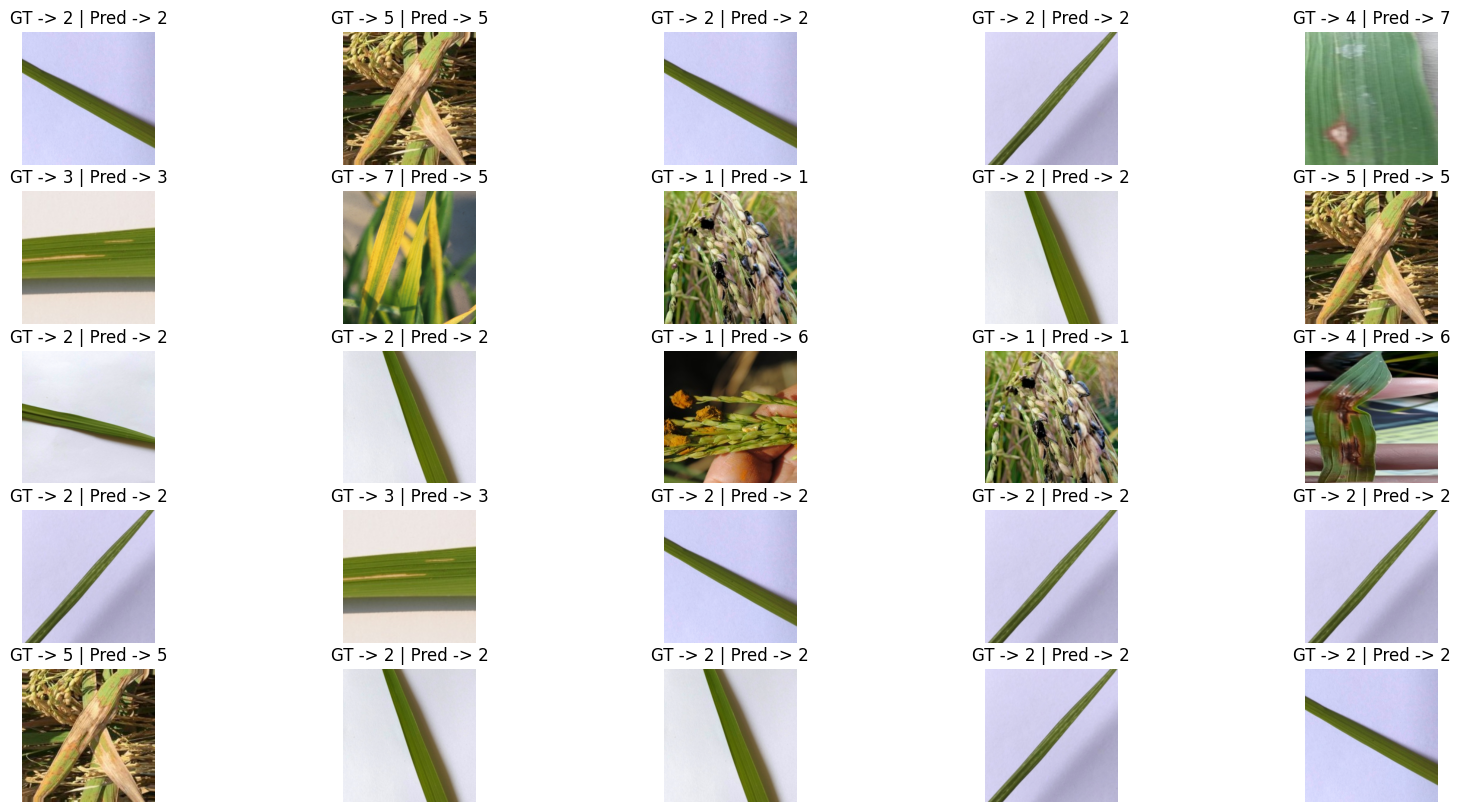

In [84]:
import random 
from utils import tensor_2_im 

num_rasm , row = 25 , 5 


plt.figure(figsize = (20 , 10))
indekslar = [random.randint(0 , len(images ) - 1 ) for _ in range(num_rasm)]

for i , indeks in enumerate (indekslar ) : 
    rasm = images[indeks]
    javob = lbls[indeks]
    pred = preds[indeks]
    
    plt.subplot(row , num_rasm // row , i + 1) 
    plt.imshow(tensor_2_im(rasm , t_type = "gray"))
    plt.axis("off")
    plt.title(f"GT -> {javob} | Pred -> {pred.item()}")

In [60]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("leaf_desease_2.jpeg")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


torch.Size([3, 224, 224])


torch.Size([1, 32, 28, 28])


'Stem rot'

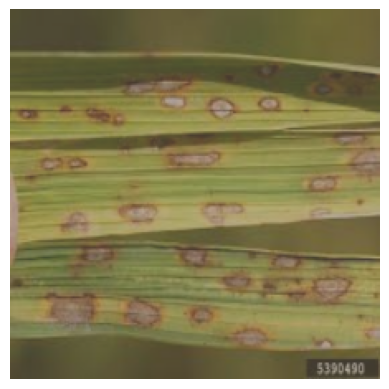

In [68]:

pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_ismi.keys())[pred_class.item()]
# plt.title  (klass_ismi[pred_class.item()])

torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


'Brown Spot'

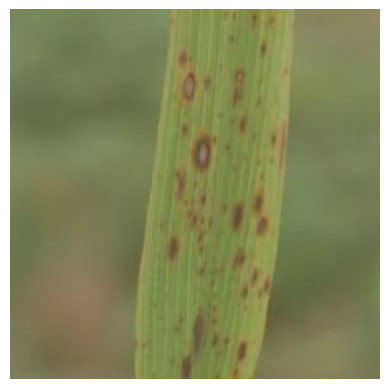

In [81]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("leaf_desease_3.jpeg.")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_ismi.keys())[pred_class.item()]
# plt.title  (klass_ismi[pred_class.item()])

torch.Size([3, 224, 224])
torch.Size([1, 32, 28, 28])


'sheath_blight'

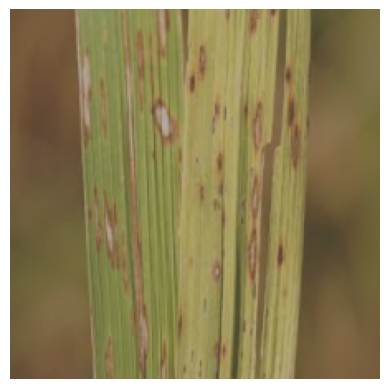

In [82]:
from PIL import Image
import torchvision.transforms as tfs

rasm = Image.open("lef_desease_1.jpeg.")

ts_ts = tfs.Compose([
    tfs.Resize((224, 224)),
    tfs.ToTensor(),
    tfs.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

tensor_im = ts_ts(rasm)
print(tensor_im.shape)


pred = model(tensor_im.unsqueeze(dim=0))
pred_class = torch.argmax(pred, dim = 1)
plt.imshow(tensor_2_im(tensor_im, t_type= "rgb"))
plt.axis('off')
list(klass_ismi.keys())[pred_class.item()]
# plt.title  (klass_ismi[pred_class.item()])